# Inroduction


This sample notebook demonstrates how to process live data streams using Pathway. The dataset used here is a subset of the one provided — specifically, it includes data for only a single parking spot. You are expected to implement your model across all parking spots.

Please note that the pricing model used in this notebook is a simple baseline. You are expected to design and implement a more advanced and effective model.


In [1]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.6/77.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.6/777.6 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.6/244.6 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.8/985.8 kB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Importing and Preprocessing the Data

In [4]:
df = pd.read_csv('/content/drive/MyDrive/SA_Capstone_Project/Copy of dataset.csv')
df
df.describe()

,ID,Capacity,Latitude,Longitude,Occupancy,QueueLength,IsSpecialDay
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,4.587925,0.150915
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,2.580062,0.357975
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.000000,0.000000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,2.000000,0.000000
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,4.000000,0.000000
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,6.000000,0.000000
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,15.000000,1.000000


In [5]:
# parking spaces sizes
(df['Capacity'].unique())

array([ 577,  387,  470,  687, 1200,  485,  690, 2009, 2803, 3883, 2937,
       1322, 3103, 1920])

#  Encoding and Creating Features

In [6]:
df['VehicleType'] = df['VehicleType'].replace({
    'cycle': 0.125,
    'bike': 0.25,
    'car': 0.5,
    'truck': 1
})

df['TrafficConditionNearby'] = df['TrafficConditionNearby'].replace({
    'high': 1,
    'average': 0.75,
    'low': 0.5
})

# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')
# created fill% to use instead of capacity
df['fill_percent'] = df['Occupancy']/df['Capacity']

#Creating Demand column using features
df['Demand'] = 0.4*(np.exp(2 * df['fill_percent'])-1) + 0.3*(np.exp(2 * df['QueueLength']/df['QueueLength'].max()) - 1) +  0.2*(df['VehicleType'])  # + 0.3*(df['TrafficConditionNearby'])
# not including traffic condition to prevent redundancy as it has very high correlation with Queue length.
# Haven't used IsSpecialDay. Reason is given later
df['Rolling_Demand'] = df['Demand'].rolling(window = 3, min_periods=1, center=True).mean()
df.describe()
# for one parking space only


,ID,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,Timestamp,fill_percent,Demand,Rolling_Demand
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,0.463803,0.700240,4.587925,0.150915,2016-11-11 10:22:39.283536640,0.509119,1.233242,1.233244
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.125000,0.500000,0.000000,0.000000,2016-10-04 07:59:00,0.003466,0.052783,0.076311
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,0.250000,0.500000,2.000000,0.000000,2016-10-24 09:48:45,0.307110,0.658620,0.695288
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,0.500000,0.750000,4.000000,0.000000,2016-11-11 11:43:30,0.496124,1.083861,1.081897
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,0.500000,0.750000,6.000000,0.000000,2016-11-29 13:36:15,0.701031,1.675778,1.652183
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,1.000000,1.000000,15.000000,1.000000,2016-12-19 16:30:00,1.041344,4.029765,3.950476
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,0.221785,0.195243,2.580062,0.357975,NaN,0.246143,0.719699,0.695325


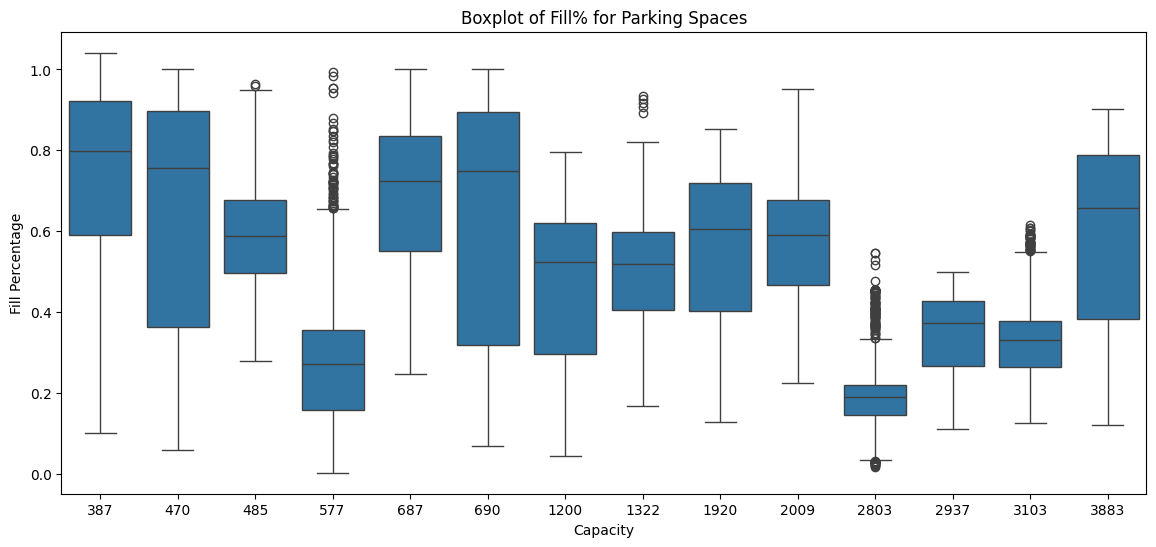

In [7]:
# Select 14 most frequent capacity values
top_capacities = df['Capacity'].value_counts().nlargest(14).index

# Filter the dataframe for these capacities
df_top = df[df['Capacity'].isin(top_capacities)]

plt.figure(figsize=(14, 6))
sns.boxplot(x='Capacity', y='fill_percent', data=df_top, order=sorted(top_capacities))
plt.xlabel('Capacity')
plt.ylabel('Fill Percentage')
plt.title('Boxplot of Fill% for Parking Spaces')
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler
temp = df[['Demand', 'Rolling_Demand']]
scaler = MinMaxScaler(feature_range=(-0.5, 4))
temp = scaler.fit_transform(temp) #need to reshape the 1D series to a 2D df to apply scaler if temp only has one column
df[['Demand', 'Rolling_Demand']] = temp
df.describe()

,ID,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,Timestamp,fill_percent,Demand,Rolling_Demand
count,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368.000000,18368,18368.000000,18368.000000,18368.000000
mean,9183.500000,1605.214286,25.706547,90.751170,731.084059,0.463803,0.700240,4.587925,0.150915,2016-11-11 10:22:39.283536640,0.509119,0.835704,0.843825
min,0.000000,387.000000,20.000035,78.000003,2.000000,0.125000,0.500000,0.000000,0.000000,2016-10-04 07:59:00,0.003466,-0.500000,-0.500000
25%,4591.750000,577.000000,26.140048,91.727995,322.000000,0.250000,0.500000,2.000000,0.000000,2016-10-24 09:48:45,0.307110,0.185512,0.218967
50%,9183.500000,1261.000000,26.147482,91.729511,568.000000,0.500000,0.750000,4.000000,0.000000,2016-11-11 11:43:30,0.496124,0.666676,0.668028
75%,13775.250000,2803.000000,26.147541,91.736172,976.000000,0.500000,0.750000,6.000000,0.000000,2016-11-29 13:36:15,0.701031,1.336438,1.330439
max,18367.000000,3883.000000,26.150504,91.740994,3499.000000,1.000000,1.000000,15.000000,1.000000,2016-12-19 16:30:00,1.041344,4.000000,4.000000
std,5302.529208,1131.153886,1.582749,3.536636,621.164982,0.221785,0.195243,2.580062,0.357975,NaN,0.246143,0.814348,0.807648


Checking data for one Parking

In [9]:
# Analysis for one parking space
# These are the List of all Parking Spaces.
#[ 577,  387,  470,  687, 1200,  485,  690, 2009, 2803, 3883, 2937, 1322, 3103, 1920]
df2 = df[df['Capacity']==577] #Substitue the value to look for data of that Parking Price

# Feature Analysis

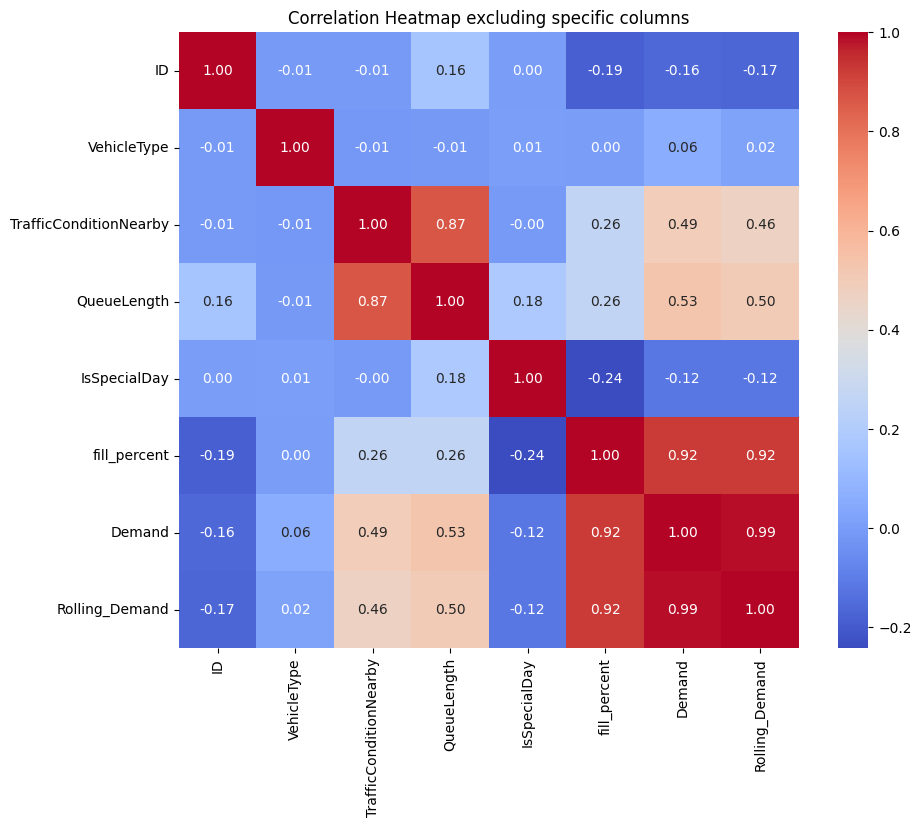

In [10]:
# Generate heatmap excluding specific columns
import seaborn as sns
columns_to_exclude = ['SystemCodeNumber', 'LastUpdatedDate', 'LastUpdatedTime', 'Timestamp', 'Capacity', 'Latitude', 'Longitude', 'Occupancy']
df2_heatmap = df.drop(columns=columns_to_exclude)

plt.figure(figsize=(10, 8))
sns.heatmap(df2_heatmap.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap excluding specific columns')
plt.show()

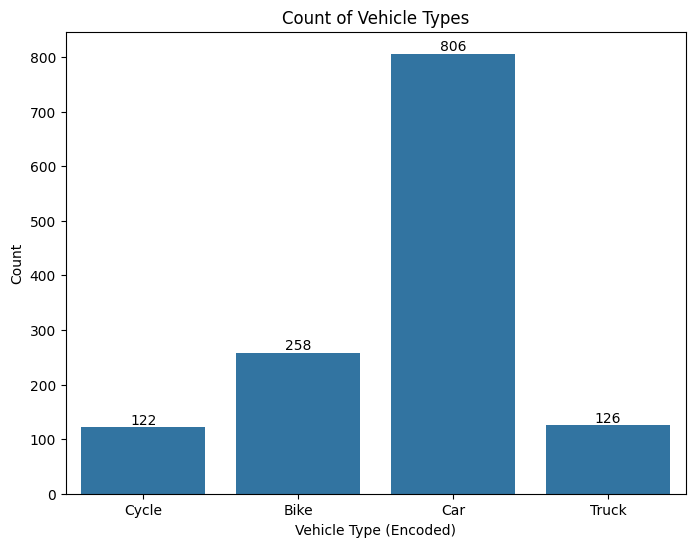

In [12]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='VehicleType', data=df2)
plt.title('Count of Vehicle Types')
plt.xlabel('Vehicle Type (Encoded)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Cycle', 'Bike', 'Car', 'Truck'])
for p in ax.patches:
    count = int(p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count}', (x, y), ha='center', va='bottom', fontsize=10)
plt.show()

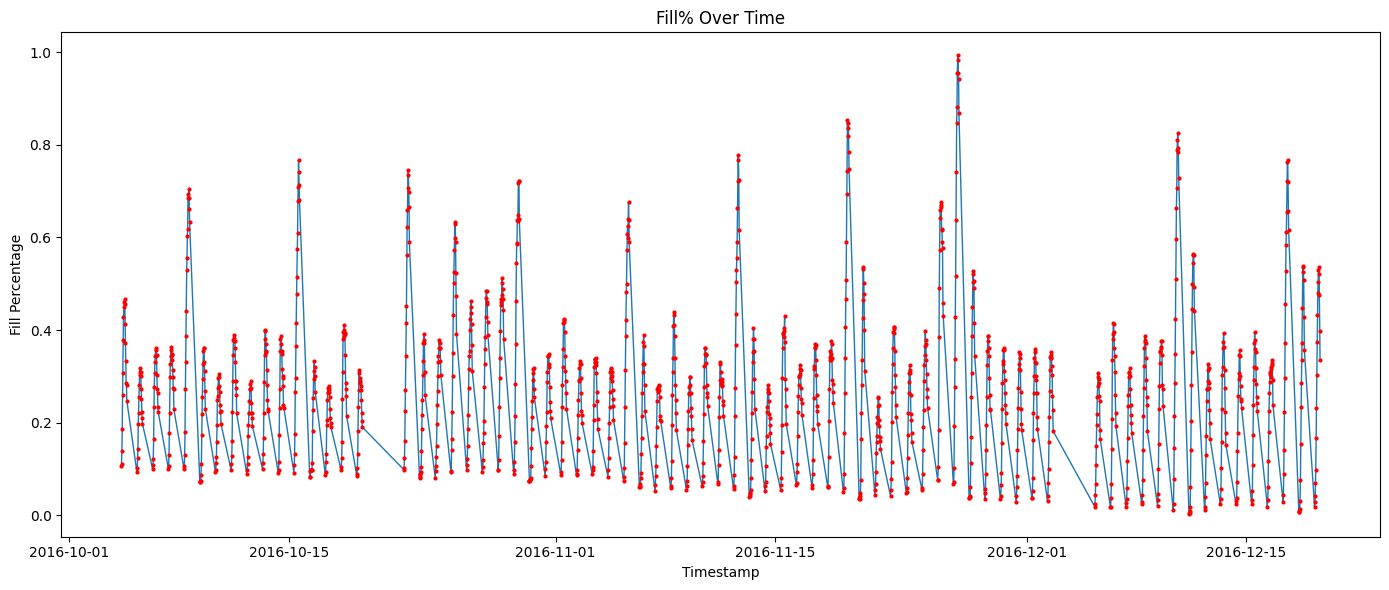

In [13]:
#fill_percent vs time
plt.figure(figsize=(14, 6))
plt.plot(df2['Timestamp'], df2['fill_percent'], marker='o', markersize=2, linestyle='-', linewidth=1, markerfacecolor='red', markeredgecolor='red')
plt.xlabel('Timestamp')
plt.ylabel('Fill Percentage')
plt.title('Fill% Over Time')
plt.tight_layout()
plt.show()

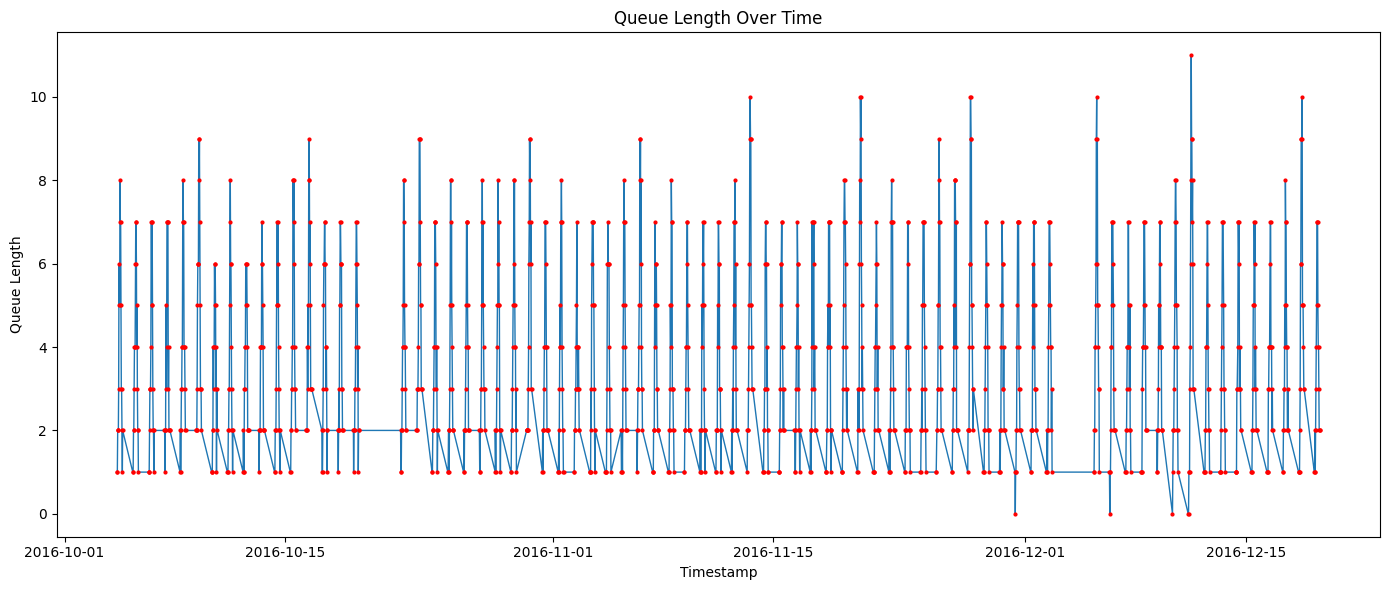

In [15]:
# QueueLength vs Capacity
plt.figure(figsize=(14, 6))
plt.plot(df2['Timestamp'], df2['QueueLength'], marker='o', markersize=2, linestyle='-', linewidth=1, markerfacecolor='red', markeredgecolor='red')
plt.xlabel('Timestamp')
plt.ylabel('Queue Length')
plt.title('Queue Length Over Time')
plt.tight_layout()
plt.show()

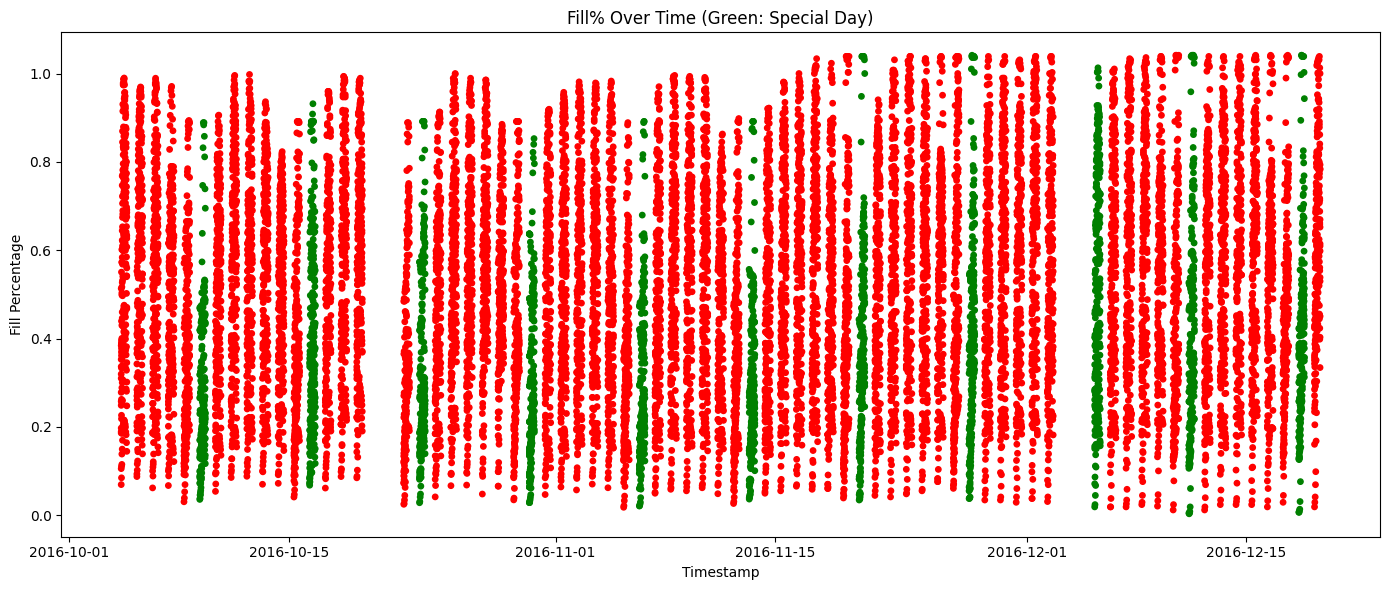

In [14]:
# highlighted sundays with green
colors = df['IsSpecialDay'].map({1: 'green', 0: 'red'})
plt.figure(figsize=(14, 6))
plt.scatter(df['Timestamp'], df['fill_percent'], c=colors, s=15)
plt.xlabel('Timestamp')
plt.ylabel('Fill Percentage')
plt.title('Fill% Over Time (Green: Special Day)')
plt.tight_layout()
plt.show()

No Correlation of IsSpecialDay with Capacity so haven't included it in Demand

In [16]:
# Save the selected columns to a CSV file for streaming or downstream processing
df2[["Timestamp","Demand","Rolling_Demand"]].to_csv("parking_stream.csv", index=False)

# Pathway Implementation

In [17]:
# Define the schema for the streaming data using Pathway
# This schema specifies the expected structure of each data row in the stream

class ParkingSchema(pw.Schema):
    Timestamp: str   # Timestamp of the observation (should ideally be in ISO format)
    Demand: float
    Rolling_Demand: float

In [18]:
# Load the data as a simulated stream using Pathway's replay_csv function
# This replays the CSV data at a controlled input rate to mimic real-time streaming
# input_rate=1000 means approximately 1000 rows per second will be ingested into the stream.

data = pw.demo.replay_csv("parking_stream.csv", schema=ParkingSchema, input_rate=1000)

In [19]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)


# Making a simple pricing function

In [20]:
# Define a daily tumbling window over the data stream using Pathway
# This block performs temporal aggregation and computes a dynamic price for each day
import datetime

delta_window = data_with_time.with_columns(
    price = 10*(1+ 0.1*pw.this.Demand),
    rolling_price = 10*(1+ 0.1*pw.this.Rolling_Demand)
).select(
    t = pw.this.t,
    price = pw.this.price,
    rolling_price = pw.this.rolling_price
)


#  Visualizing Daily Price Fluctuations with a Bokeh Plot

**Note:** The Bokeh plot in the next cell will only be generated after you run the `pw.run()` cell (i.e., the final cell).


In [21]:
# Activate the Panel extension to enable interactive visualizations
pn.extension()

# Define a custom Bokeh plotting function that takes a data source (from Pathway) and returns a figure
def price_plotter(source):
    # Create a Bokeh figure with datetime x-axis
    fig = bokeh.plotting.figure(
        height=300,
        width=2000,
        title="Pathway: Daily Parking Price",
        x_axis_type="datetime",  # Ensure time-based data is properly formatted on the x-axis
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("t", "price", source=source, line_width=2, color="navy", legend_label = 'Price')
    fig.line("t", "rolling_price", source=source, line_width=2, color="green", legend_label = 'Rolling Price')

    # Overlay red circles at each data point for better visibility
    fig.circle("t", "price", source=source, size=2, color="red", legend_label = 'Price Points')
    fig.legend.location = "top_left"       # Place the legend
    fig.legend.click_policy = "hide"      # Allow toggling visibility

    return fig

# Use Pathway's built-in .plot() method to bind the data stream (delta_window) to the Bokeh plot
# - 'price_plotter' is the rendering function
# - 'sorting_col="t"' ensures the data is plotted in time order
viz = delta_window.plot(price_plotter, sorting_col="t")

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
pn.Column(viz).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [22]:
# Start the Pathway pipeline execution in the background
# - This triggers the real-time data stream processing defined above
# - %%capture --no-display suppresses output in the notebook interface

%%capture --no-display
pw.run()

Output()

# Prices for Vehicle Types

In [23]:
#creating vehicle features
df2['cycle_demand'] = df2[df2['VehicleType'] == 0.125]['Rolling_Demand']
df2['bike_demand'] = df2[df2['VehicleType'] == 0.25]['Rolling_Demand']
df2['car_demand'] = df2[df2['VehicleType'] == 0.5]['Rolling_Demand']
df2['truck_demand'] = df2[df2['VehicleType'] == 1]['Rolling_Demand']

#interpolating the Null values
df2['cycle_demand'].interpolate(method='linear', inplace=True)
df2['bike_demand'].interpolate(method='linear', inplace=True)
df2['car_demand'].interpolate(method='linear', inplace=True)
df2['truck_demand'].interpolate(method='linear', inplace=True)

In [24]:
#Filling the remaining null values with 0
df2.fillna(0, inplace=True)
df2

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime,Timestamp,fill_percent,Demand,Rolling_Demand,cycle_demand,bike_demand,car_demand,truck_demand
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,0.500,0.50,1,0,04-10-2016,07:59:00,2016-10-04 07:59:00,0.105719,-0.291589,-0.310387,0.000000,0.000000,-0.310387,0.000000
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,0.500,0.50,1,0,04-10-2016,08:25:00,2016-10-04 08:25:00,0.110919,-0.285744,-0.279432,0.000000,0.000000,-0.279432,0.000000
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,0.500,0.50,2,0,04-10-2016,08:59:00,2016-10-04 08:59:00,0.138648,-0.198201,-0.227427,0.000000,0.000000,-0.227427,0.000000
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,0.500,0.50,2,0,04-10-2016,09:32:00,2016-10-04 09:32:00,0.185442,-0.139608,-0.160712,0.000000,0.000000,-0.160712,0.000000
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,0.250,0.50,2,0,04-10-2016,09:59:00,2016-10-04 09:59:00,0.259965,-0.090774,-0.057409,0.000000,-0.057409,0.016950,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,1307,BHMBCCMKT01,577,26.144536,91.736172,309,0.500,0.75,4,0,19-12-2016,14:30:00,2016-12-19 14:30:00,0.535529,0.660913,0.590533,0.445852,0.680299,0.590533,0.330692
1308,1308,BHMBCCMKT01,577,26.144536,91.736172,300,0.125,0.50,3,0,19-12-2016,15:03:00,2016-12-19 15:03:00,0.519931,0.463250,0.469734,0.469734,0.680299,0.446266,0.330692
1309,1309,BHMBCCMKT01,577,26.144536,91.736172,274,0.125,0.50,2,0,19-12-2016,15:29:00,2016-12-19 15:29:00,0.474870,0.289698,0.315120,0.315120,0.680299,0.301998,0.330692
1310,1310,BHMBCCMKT01,577,26.144536,91.736172,230,0.500,0.75,2,0,19-12-2016,16:03:00,2016-12-19 16:03:00,0.398614,0.209062,0.157731,0.194740,0.680299,0.157731,0.330692


In [25]:
df2[["Timestamp","cycle_demand","bike_demand", "car_demand", "truck_demand"]].to_csv("vehicle_parking_stream.csv", index=False)

In [26]:
class VehicleParkingSchema(pw.Schema):
    Timestamp: str
    cycle_demand: float
    bike_demand: float
    car_demand: float
    truck_demand: float

In [27]:
vehicle_data = pw.demo.replay_csv("vehicle_parking_stream.csv", schema=VehicleParkingSchema, input_rate=1000)

In [28]:
# Define the datetime format to parse the 'Timestamp' column
fmt2 = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
vehicle_data_with_time = vehicle_data.with_columns(
    veh_t = vehicle_data.Timestamp.dt.strptime(fmt2),
    veh_day = vehicle_data.Timestamp.dt.strptime(fmt2).dt.strftime("%Y-%m-%dT00:00:00")
)

In [29]:
# The car's standard parking price is 10 and other prices are varied accordingly
vehicle_delta_window = vehicle_data_with_time.with_columns(
    cycle_price = 10*(1+ 0.1*pw.this.cycle_demand)*0.25,
    bike_price = 10*(1+ 0.1*pw.this.bike_demand)*0.5,
    car_price = 10*(1+ 0.1*pw.this.car_demand),
    truck_price = 10*(1+ 0.1*pw.this.truck_demand)*2
).select(
    veh_t = pw.this.veh_t,
    cycle_price = pw.this.cycle_price,
    bike_price = pw.this.bike_price,
    car_price = pw.this.car_price,
    truck_price = pw.this.truck_price
)

In [30]:
# Activate the Panel extension to enable interactive visualizations
pn.extension()

# Define a custom Bokeh plotting function that takes a data source (from Pathway) and returns a figure
def vehicle_price_plotter(source):
    # Create a Bokeh figure with datetime x-axis
    fig = bokeh.plotting.figure(
        height=300,
        width=2000,
        title="Pathway: Daily Parking Price",
        x_axis_type="datetime",  # Ensure time-based data is properly formatted on the x-axis
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("veh_t", "cycle_price", source=source, line_width=2, color="navy", legend_label="Cycle")
    fig.line("veh_t", "bike_price", source=source, line_width=2, color="green", legend_label="Bike")
    fig.line("veh_t", "car_price", source=source, line_width=2, color="red", legend_label="Car")
    fig.line("veh_t", "truck_price", source=source, line_width=2, color="orange", legend_label="Truck")
    fig.legend.location = "top_left"       # Place the legend
    fig.legend.click_policy = "hide"      # Allow toggling visibility

    return fig

viz2 = vehicle_delta_window.plot(vehicle_price_plotter, sorting_col="veh_t")

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
pn.Column(viz2).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [48]:
# Start the Pathway pipeline execution in the background
# - This triggers the real-time data stream processing defined above
# - %%capture --no-display suppresses output in the notebook interface

%%capture --no-display
pw.run()

Output()

### Competitor Analysis

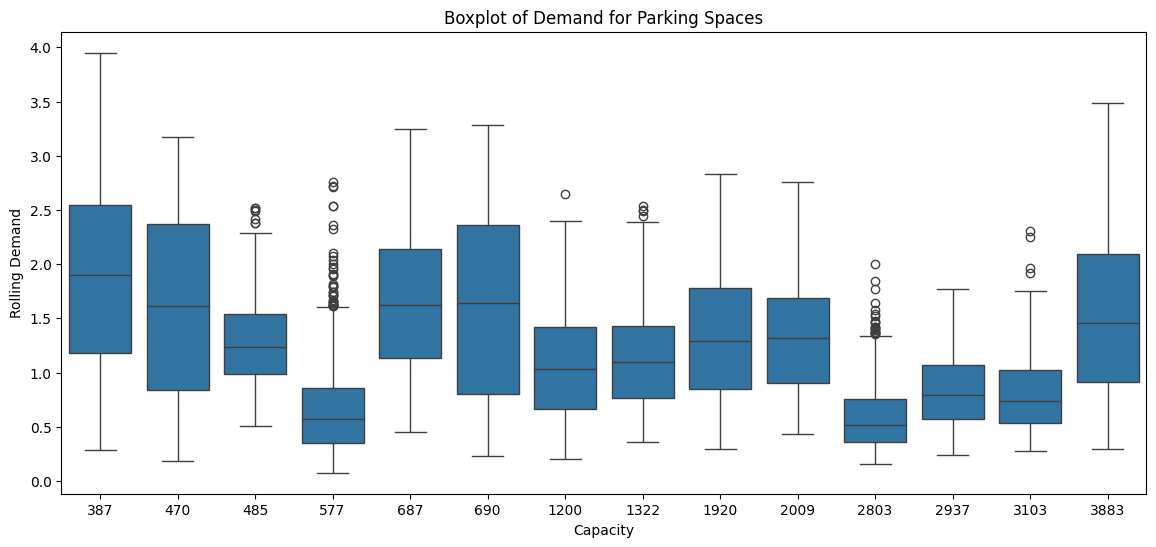

In [32]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Capacity', y='Rolling_Demand', data=df_top, order=sorted(top_capacities))
plt.xlabel('Capacity')
plt.ylabel('Rolling Demand')
plt.title('Boxplot of Demand for Parking Spaces')
plt.show()

In [33]:
import matplotlib.cm as cm

# Aggregate demand by Capacity and Timestamp
df_agg = df.groupby(['Capacity', 'Timestamp'])['Demand'].mean().reset_index()

plt.figure(figsize=(200, 5))

# Get the unique capacities
capacities = df_agg['Capacity'].unique()
n = len(capacities)

# Use a qualitative colormap to generate colors
cmap = cm.get_cmap('tab20', n)

for i, capacity in enumerate(capacities):
    df_cap = df_agg[df_agg['Capacity'] == capacity]
    plt.plot(
        df_cap['Timestamp'],
        df_cap['Demand'],
        color=cmap(i),
        alpha=0.6,
        linewidth=2,
        label=f'Capacity: {capacity}'
    )

plt.xlabel('Timestamp')
plt.ylabel('Demand')
plt.title('Demand Over Time for Different Parking Capacities')
plt.legend(title='Capacity', loc='upper left', ncol=5)
plt.tight_layout()
plt.show()
# click on the plot below to get the detailed view of it if it looks small.

Output hidden; open in https://colab.research.google.com to view.

Sorting by Most Average Demand

In [34]:
df_demand_mean = df.groupby('Capacity')["Demand"].mean().reset_index()
df_coordinates = df.groupby('Capacity')[['Latitude', 'Longitude']].first().reset_index()
df_merged = pd.merge(df_demand_mean, df_coordinates, on='Capacity', how='outer')
df_merged.sort_values(by= "Demand" ,ascending = False, inplace = True)
df_merged

,Capacity,Demand,Latitude,Longitude
0,387,1.595344,26.144495,91.736205
4,687,1.333632,20.000035,78.000003
1,470,1.263930,26.149020,91.739503
5,690,1.253253,26.137958,91.740994
13,3883,1.152372,26.147499,91.728005
8,1920,0.940066,26.150504,91.733531
9,2009,0.935261,26.147473,91.728049
2,485,0.880320,26.140048,91.730972
7,1322,0.708815,26.147549,91.727995
6,1200,0.633609,26.140014,91.731000


Sorting by Most Standard Deviation

In [36]:
df_demand_std = df.groupby('Capacity')["Demand"].std().reset_index()
df_demand_std.sort_values(by= "Demand" ,ascending = False, inplace = True)
df_demand_std

,Capacity,Demand
0,387,1.030154
5,690,1.010885
1,470,1.003401
13,3883,0.827529
4,687,0.751495
8,1920,0.664069
9,2009,0.572870
6,1200,0.553528
7,1322,0.503550
3,577,0.470894


Plotting a Spacial Map of Parking Spaces

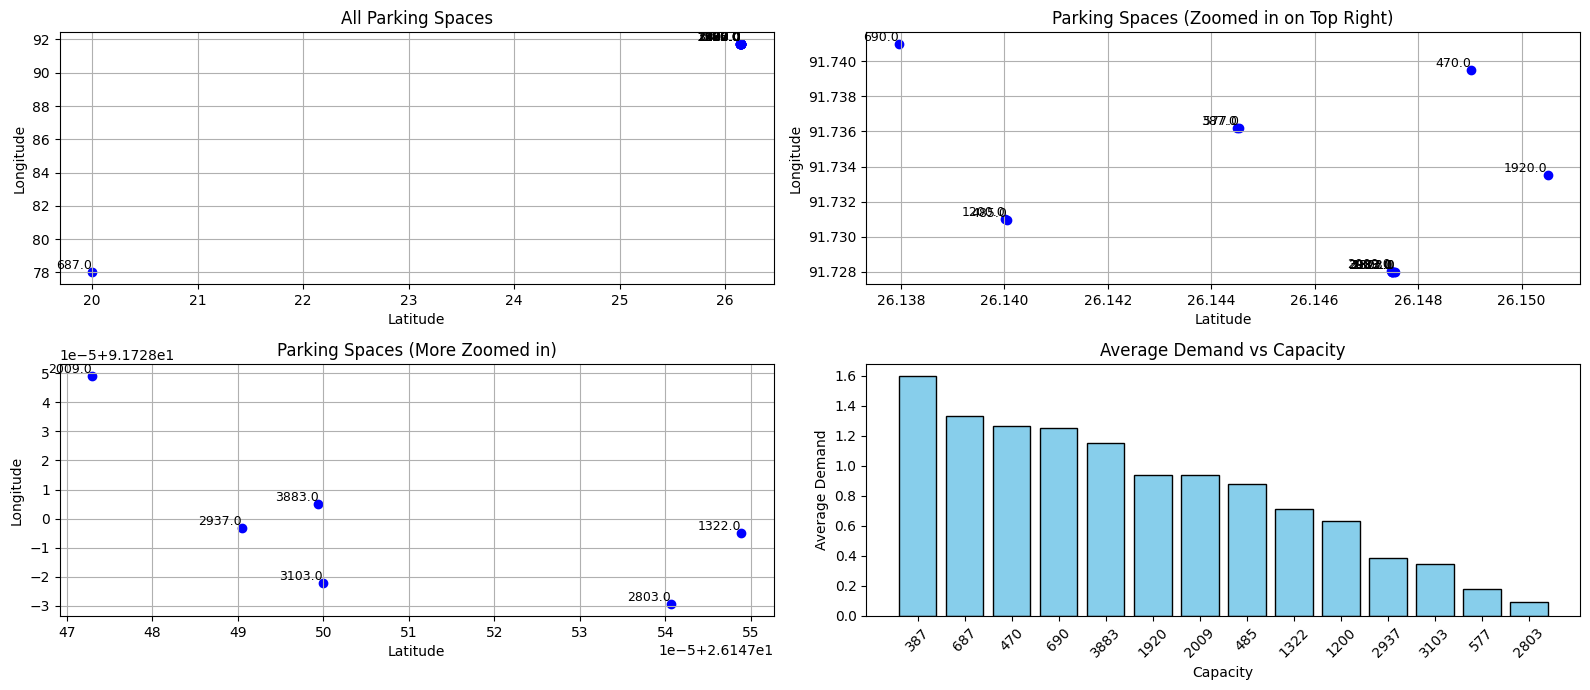

In [49]:
df_merged2 = df_merged[df_merged['Capacity']!=687]
df_merged3 = df_merged[df_merged['Capacity'].isin([2009, 2937, 3883, 3103, 1322, 2803])]

def plot_parking_spaces(ax, df, title):
    ax.scatter(df['Latitude'], df['Longitude'], color='blue')
    for i, row in df.iterrows():
        ax.text(row['Latitude'], row['Longitude'], str(row['Capacity']),
                fontsize=9, ha='right', va='bottom')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_title(title)
    ax.grid(True)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 7))

# Plot for df_merged
plot_parking_spaces(axs[0, 0], df_merged, 'All Parking Spaces')

# Plot for df_merged2
plot_parking_spaces(axs[0, 1], df_merged2, 'Parking Spaces (Zoomed in on Top Right)')

plot_parking_spaces(axs[1, 0], df_merged3, 'Parking Spaces (More Zoomed in)')

axs[1, 1].bar(
    df_merged['Capacity'].astype(str),  # x-axis: Capacity as string to avoid spacing issues
    df_merged['Demand'],                # y-axis: Average demand
    color='skyblue',
    edgecolor='black'
)

# Labeling and styling
axs[1, 1].set_xlabel('Capacity')
axs[1, 1].set_ylabel('Average Demand')
axs[1, 1].set_title('Average Demand vs Capacity')
axs[1, 1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

(**EXTRA**) Additional Plot for Spacial viewing and Zooming ability

In [37]:
import plotly.express as px

fig = px.scatter(
    df_merged,
    x='Latitude',
    y='Longitude',
    text='Capacity',  # Show capacity as label
    color='Demand',   # Color by demand for extra insight
    color_continuous_scale='Blues',
    hover_data=['Capacity', 'Demand'],
    title='Parking Spaces Map'
)

fig.update_traces(marker=dict(size=14, opacity=0.8), textposition='top right')
fig.update_layout(
    xaxis_title='Latitude',
    yaxis_title='Longitude',
    legend_title='Average Demand',
    dragmode='zoom',  # Enables zooming by default
    width=900,
    height=700
)
fig.show()